In [1]:
import os

In [2]:
%pwd

'c:\\Users\\shash\\fetch_assessment\\research'

In [3]:
os.chdir("../")

In [4]:
%pwd

'c:\\Users\\shash\\fetch_assessment'

In [5]:
from dataclasses import dataclass
from pathlib import Path

@dataclass(frozen=True)
class EvaluatingModelConfig:
    root_dir: Path
    data_path: Path
    model_path: Path

In [6]:
from fetch_assessment.constants import *
from fetch_assessment.utils.common import read_yaml, create_directories

Importing constants
Config path: config\config.yaml
Params path: params.yaml


In [14]:
class ConfigurationManager:
    def __init__(
        self,
        config_filepath = CONFIG_FILE_PATH,
        params_filepath = PARAMS_FILE_PATH):

        self.config = read_yaml(config_filepath)
        self.params = read_yaml(params_filepath)

        create_directories([self.config.artifacts_root])
        

    

    def get_evaluating_model_config(self) ->  EvaluatingModelConfig:
        config = self.config.model_training
        create_directories([config.root_dir])

        traing_model_config =  EvaluatingModelConfig(
            root_dir=config.root_dir,
            data_path=config.data_path,
            model_path=config.model_path,
                    )

        return traing_model_config

In [15]:
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import LSTM,GRU, Dense,Dropout,Bidirectional,Conv1D,Reshape,MaxPooling1D,Flatten,SimpleRNN
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import numpy as np
import joblib

In [34]:
class ModelTrainer:
    def __init__(self, config: EvaluatingModelConfig):
        self.config = config

    
    def evalating(self):
        import numpy as np

        # Load the data
        X_train = np.load(os.path.join(self.config.data_path,"X_train.npy"))
        y_train = np.load(os.path.join(self.config.data_path,"y_train.npy"))
        X_test = np.load(os.path.join(self.config.data_path,"X_test.npy"))
        y_test = np.load(os.path.join(self.config.data_path,"y_test.npy"))
        scaled_data = np.load(os.path.join(self.config.data_path,"scaled_data.npy"))
        scaler = joblib.load(os.path.join(self.config.data_path,"scaler.gz"))
        
        model=load_model(self.config.model_path)

        # Predicting on the train set
        y_pred = model.predict(X_train)
        print(y_pred.shape,y_train.shape)
        # Calculating RMSE
        rmse = np.sqrt(mean_squared_error(y_train, y_pred))
        print("Train RMSE:", rmse)

        # Reshape y_pred_scaled for inverse transformation
        temp_shape = np.zeros((len(y_pred), scaled_data.shape[1]))
        temp_shape[:, 0] = y_pred[:, 0]
        y_pred = scaler.inverse_transform(temp_shape)[:, 0]

        # Reshape y_test for inverse transformation
        y_test_temp_shape = np.zeros((len(y_train), scaled_data.shape[1]))
        y_test_temp_shape[:, 0] = y_train
        y_test_rescaled = scaler.inverse_transform(y_test_temp_shape)[:, 0]

        # Calculating RMSE on the rescaled data
        rmse = np.sqrt(mean_squared_error(y_test_rescaled, y_pred))
        print("Train RMSE on original scale:", rmse)
        
        # Predicting on the test set
        y_pred = model.predict(X_test) 
        print(y_pred.shape,y_test.shape)
        # Calculating RMSE
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        print("Test RMSE:", rmse)
        
        # Reshape y_pred_scaled for inverse transformation
        temp_shape = np.zeros((len(y_pred), scaled_data.shape[1]))
        temp_shape[:, 0] = y_pred[:, 0]
        y_pred = scaler.inverse_transform(temp_shape)[:, 0]

        # Reshape y_test for inverse transformation
        y_test_temp_shape = np.zeros((len(y_test), scaled_data.shape[1]))
        y_test_temp_shape[:, 0] = y_test
        y_test_rescaled = scaler.inverse_transform(y_test_temp_shape)[:, 0]

        # Calculating RMSE on the rescaled data
        rmse = np.sqrt(mean_squared_error(y_test_rescaled, y_pred))
        print("Test RMSE on original scale:", rmse)
        import matplotlib.pyplot as plt
        import numpy as np


        # Sample data - replace these with your actual data
        y_train_rescaled = np.random.rand(100)  # Sample training data
        y_test_rescaled = np.random.rand(50)  # Sample test data
        y_pred = np.random.rand(50)  # Sample predicted data

        # Generating indices for test data and predictions for plotting
        test_indices = np.arange(100, 150)

        # Plotting
        plt.figure(figsize=(12, 6))
        plt.plot(y_train_rescaled, label='Training Data')
        plt.plot(test_indices, y_test_rescaled, label='Test Data')
        plt.plot(test_indices, y_pred, label='Predicted Data')
        plt.xlabel('Time Steps')
        plt.ylabel('Values')
        plt.title('Comparison of Train, Test and Predicted Data')
        plt.legend()
        plt.savefig(os.path.join(self.config.root_dir, "plot.png"))
        plt.show()





[2023-11-13 16:33:45,873: INFO: common: yaml file: config\config.yaml loaded successfully]
[2023-11-13 16:33:45,876: INFO: common: yaml file: params.yaml loaded successfully]
[2023-11-13 16:33:45,880: INFO: common: created directory at: artifacts]
[2023-11-13 16:33:45,880: INFO: common: created directory at: artifacts/model_training]
9/9 [==============================] - 0s 3ms/step
(284, 1) (284,)
Train RMSE: 0.06481052015303362
Train RMSE on original scale: 229700.0196949385
3/3 [==============================] - 0s 2ms/step
(71, 1) (71,)
Test RMSE: 0.07359339388657422
Test RMSE on original scale: 260828.087558131


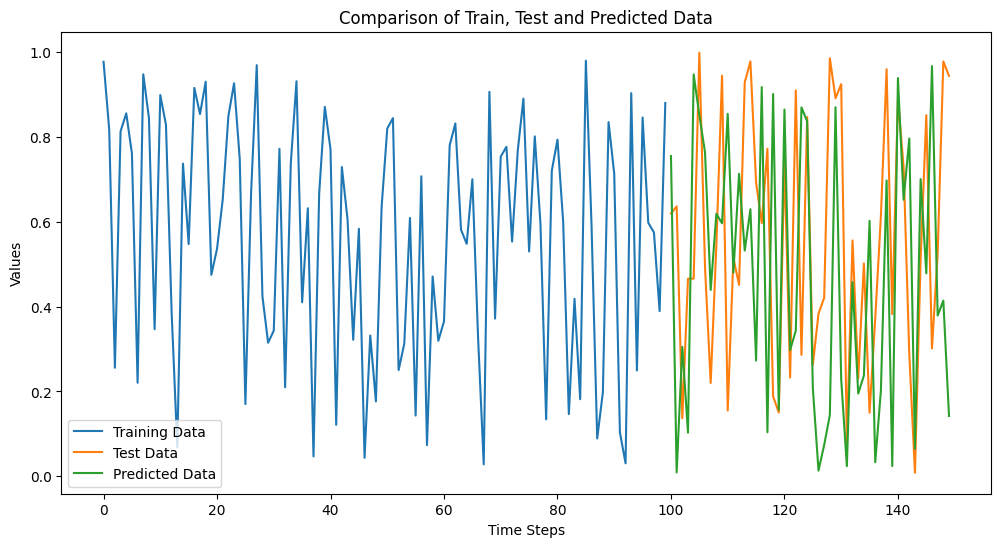

In [35]:
config = ConfigurationManager()
model_trainer_config = config.get_evaluating_model_config()
model_evaluator = ModelTrainer(config=model_trainer_config)
model_evaluator.evalating()